# Add title

## Import libraries

In [1]:
import numpy as np
import plaidml.keras
import os
plaidml.keras.install_backend()
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

from keras import backend as K
print(K)

import keras
from keras.preprocessing.image import ImageDataGenerator

print("Keras version %s" %keras.__version__)

<module 'plaidml.keras.backend' from 'E:\\anaconda3\\envs\\plaidML\\lib\\site-packages\\plaidml\\keras\\backend.py'>
Keras version 2.2.4


## Load data and get mel spectrogram from audio

In [2]:
# Load various imports 
import pandas as pd
import os
import librosa

max_pad_len = 174

def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs
    
# Set the path to the full UrbanSound dataset 
fulldatasetpath = '/Xception/UrbanSound8K/audio/'

metadata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')

features = []

# Iterate through each sound file and extract the features 
for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"]),str(row["slice_file_name"]))
    
    class_label = row["class"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files')

E:\anaconda3\envs\plaidML\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
E:\anaconda3\envs\plaidML\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
E:\anaconda3\envs\plaidML\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(


Finished feature extraction from  8732  files


## Preprocess data

In [4]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

## Model definition

In [5]:
from keras.models import Model
from keras.layers import SeparableConv2D, ZeroPadding2D, Activation, Dropout, Dense, \
                            Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras import Input, optimizers

num_rows = 40
num_columns = 174
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]

def Net(input_shape, num_classes, dilated_kernel, dilation, dilated_padding):
    
    # input layer
    inputs = Input(shape=(num_rows, num_columns, num_channels))
    
    # DWS-CNN layer 1
    x = ZeroPadding2D(padding=(2))(inputs)
    # use valid padding since padding is introduced before since it has a special form
    x = SeparableConv2D(256,kernel_size=(5,5), strides=(1,1), padding='valid')(x)
    x = Activation('relu')(x)
    # Batch Normalisation before passing it to the next layer
    x = BatchNormalization()(x)
    # Pooling
    x = MaxPooling2D(pool_size=(1,5), strides=(1,5), padding='valid')(x)
    # Dropout
    x = Dropout(0.25)(x)
    
    # DWS-CNN layer 2
    x = ZeroPadding2D(padding=(2))(x)
    # use valid padding since padding is introduced before since it has a special form
    x = SeparableConv2D(256,kernel_size=(5,5), strides=(1,1), padding='valid')(x)
    x = Activation('relu')(x)
    # Batch Normalisation before passing it to the next layer
    x = BatchNormalization()(x)
    # Pooling
    x = MaxPooling2D(pool_size=(1,4), strides=(1,4), padding='valid')(x)
    # Dropout
    x = Dropout(0.25)(x)
    
    # DWS-CNN layer 3
    x = ZeroPadding2D(padding=(2))(x)
    # use valid padding since padding is introduced before since it has a special form
    x = SeparableConv2D(256,kernel_size=(5,5), strides=(1,1), padding='valid')(x)
    x = Activation('relu')(x)
    # Batch Normalisation before passing it to the next layer
    x = BatchNormalization()(x)
    # Pooling
    x = MaxPooling2D(pool_size=(1,2), strides=(1,2), padding='valid')(x)
    # Dropout
    x = Dropout(0.25)(x)
    
    # DIL-CNN 
    x = ZeroPadding2D(padding=(0, dilated_padding*dilation))(x)
    x = Conv2D(256, kernel_size=dilated_kernel, dilation_rate=(1,dilation))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # classifier layer
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    outputs = Dense(num_labels,activation='sigmoid')(x)
    
    # model compilation for training
    adam = optimizers.Adam(lr=0.0001)
    model = Model(inputs, outputs)                            
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    return model


# create the model
input_shape = (256, 256, 1)
num_classes = 10
dilated_kernel = (3,3)
dilation = (10)
dilated_padding = 2
model = Net(input_shape,num_classes,dilated_kernel,dilation,dilated_padding)
model.summary()

INFO:plaidml:Opening device "opencl_amd_gfx1010.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40, 174, 1)        0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 44, 178, 1)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 40, 174, 256)      537       
_________________________________________________________________
activation_1 (Activation)    (None, 40, 174, 256)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 174, 256)      1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 34, 256)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 34, 256)       0         
__________

## Train the model

In [6]:
#from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 50
num_batch_size = 16

#checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
#                               verbose=1, save_best_only=True)
start = datetime.now()

#history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), verbose=1)
history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_split=0.15, verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 5937 samples, validate on 1048 samples
Epoch 1/50
5937/5937 [==============================] - 139s 23ms/step - loss: 1.7905 - acc: 0.3780 - val_loss: 2.2814 - val_acc: 0.1250
Epoch 2/50
5937/5937 [==============================] - 32s 5ms/step - loss: 1.3931 - acc: 0.5307 - val_loss: 1.4479 - val_acc: 0.4933
Epoch 3/50
5937/5937 [==============================] - 32s 5ms/step - loss: 1.2036 - acc: 0.5924 - val_loss: 1.2980 - val_acc: 0.5296
Epoch 4/50
5937/5937 [==============================] - 32s 5ms/step - loss: 1.0870 - acc: 0.6358 - val_loss: 1.2052 - val_acc: 0.5229
Epoch 5/50
5937/5937 [==============================] - 33s 5ms/step - loss: 1.0083 - acc: 0.6712 - val_loss: 1.2770 - val_acc: 0.5468
Epoch 6/50
5937/5937 [==============================] - 32s 5ms/step - loss: 0.9497 - acc: 0.6820 - val_loss: 1.1621 - val_acc: 0.5697
Epoch 7/50
5937/5937 [==============================] - 32s 5ms/step - loss: 0.8904 - acc: 0.7034 - val_loss: 1.1333 - val_acc: 0.6040
Epoch

In [7]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=num_batch_size)
print("test loss, test acc:", results)

Evaluate on test data
1747/1747 [==============================] - 13s 8ms/step
test loss, test acc: [0.39252389369731844, 0.8700629650829994]


## Plot Results

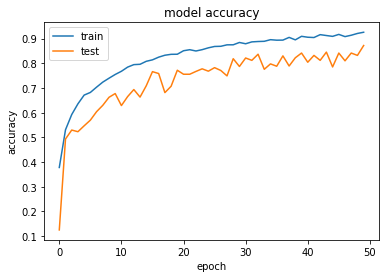

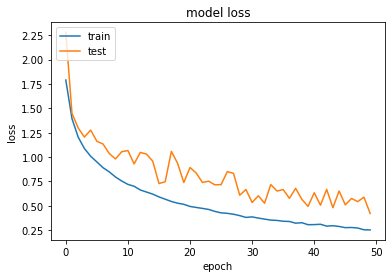

In [12]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()